<a href="https://colab.research.google.com/github/MirRinat/Hackaton21/blob/master/final_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import sklearn as sl
import matplotlib.pyplot as plt

### Загрузка файлов

In [0]:
train_data = pd.read_csv("/content/drive/My Drive/school-21-student-expulsion-prediction/train.csv")

In [179]:
train_data.head()

,id,Birth date,Native city,Gender,Wave id,Level,Heard about school from,Life status,day_00,day_01,day_02,day_03,day_04,day_05,day_06,day_07,day_08,day_09,day_10,day_11,day_12,day_13,evalexpr,match_n_match,bsq,rush_00,rush_01,rush_02,exam_00,exam_01,exam_02,exam_final,Contract termination date,Memory entrance game,Logic entrance game,contract_status
0,129212391,1990-01-18,Пермь,male,3,7.463235,google_ads,work,5,NaN,0.0,80.0,0.0,1.0,0.0,15.0,10.0,0.0,50.0,21.0,20.0,55.0,81.0,0.0,0.0,0.0,0.0,0.0,75.0,43.0,100.0,44.0,NaN,9,11,1
1,566688420,1996-07-31,Волгоград,female,1,8.785714,NaN,NaN,0,NaN,10.0,45.0,5.0,1.0,35.0,0.0,5.0,16.0,0.0,9.0,0.0,10.0,0.0,0.0,0.0,110.0,0.0,0.0,0.0,16.0,22.0,22.0,NaN,7,10,1
2,242300495,1992-06-27,Новосибирск,female,2,6.775000,other,work,0,NaN,20.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,16.0,27.0,NaN,7,11,1
3,715424753,1996-06-15,Тула,female,1,8.146104,NaN,NaN,5,0.0,35.0,25.0,20.0,2.0,70.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,27.0,NaN,9,6,1
4,382884118,1968-07-18,Голицыно,male,3,4.272727,other,other,0,0.0,NaN,5.0,85.0,3.0,50.0,40.0,0.0,12.0,40.0,5.0,0.0,0.0,0.0,60.0,0.0,120.0,0.0,0.0,80.0,38.0,0.0,45.0,NaN,7,12,1


In [0]:
test_data = pd.read_csv("/content/drive/My Drive/school-21-student-expulsion-prediction/test.csv")

In [181]:
test_data.head()

,id,Birth date,Native city,Gender,Wave id,Level,Heard about school from,Life status,day_00,day_01,day_02,day_03,day_04,day_05,day_06,day_07,day_08,day_09,day_10,day_11,day_12,day_13,evalexpr,match_n_match,bsq,rush_00,rush_01,rush_02,exam_00,exam_01,exam_02,exam_final,Contract termination date,Memory entrance game,Logic entrance game
0,685512434,1992-09-08,г. Тюмень,male,3,8.834416,google_ads,work,10,NaN,80.0,40.0,30.0,5.0,70.0,10.0,40.0,0.0,85.0,21.0,0.0,20.0,100.0,0.0,100.0,120.0,0.0,0.0,75.0,43.0,64.0,45.0,NaN,10,12
1,157712083,1993-12-02,Москва,male,2,2.172414,from_21_student,work,7,0.0,0.0,50.0,0.0,5.0,20.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,80.0,22.0,33.0,36.0,NaN,7,6
2,672158583,1989-02-16,Москва,male,3,4.310160,from_friends,other,5,0.0,0.0,5.0,10.0,-42.0,35.0,20.0,5.0,9.0,35.0,21.0,10.0,10.0,0.0,60.0,0.0,0.0,0.0,75.0,0.0,6.0,33.0,9.0,NaN,7,10
3,1205321261,1997-07-16,Дзержинский,female,2,6.295833,other,study,20,0.0,30.0,0.0,10.0,0.0,20.0,0.0,0.0,NaN,10.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,15.0,1.0,16.0,22.0,NaN,9,8
4,621191476,1997-02-22,Москва,male,1,7.110294,NaN,NaN,100,100.0,80.0,30.0,0.0,2.0,0.0,40.0,10.0,6.0,0.0,-42.0,0.0,15.0,0.0,60.0,100.0,0.0,0.0,0.0,65.0,65.0,54.0,36.0,NaN,9,15


In [0]:
sample_submission = pd.read_csv("/content/drive/My Drive/school-21-student-expulsion-prediction/sample_submission.csv")

In [183]:
sample_submission.head()

,id,contract_status
0,685512434,0
1,157712083,0
2,672158583,0
3,1205321261,0
4,621191476,0


### Обработка данных, генерация фичей

In [0]:
del train_data['Contract termination date'], train_data['Level']
del test_data['Contract termination date'], test_data['Level']

# не нужно
del train_data['id']

###### Город рождения

In [0]:
from string import punctuation
from operator import itemgetter as at

def is_from_city(raw_city, city_names):
  return raw_city.fillna('NULL').str.split().map(at(-1)).str.strip(punctuation)\
                    .str.lower().str.replace('ё', 'e').isin(city_names)

moscow_names = ['москва', 'moscow']

moscow_suburbs = [
  'балашиха', 'мытищи', 'долгопрудный', 'красногорск',
  'реутов', 'люберцы', 'химки', 'одинцово', 'котельники',
  'подольск', 'железнодорожный', 'жуковский', 'королев'
]


for df in [train_data, test_data]:
  df['moscow_citizen'] = is_from_city(df['Native city'], moscow_names)
  df['from_moscow_suburb'] = is_from_city(df['Native city'], moscow_suburbs)
  df['Native city'].fillna('NULL', inplace=True)

##### Возраст

In [0]:
def get_age(birth_date):
  return (pd.to_datetime('2019-08-31') - pd.to_datetime(birth_date)).dt.days // 365


for df in [train_data, test_data]:
  df['age'] = get_age(df['Birth date'])
  df['over_32_yo'] = df['Birth date'] >= '1989-08-31'
  df['less_24_yo'] = df['Birth date'] <= '1996-08-31'
  del df['Birth date']

##### Данные об успеваемости

In [0]:
perfomance_columns = {
  'workday': df.columns[df.columns.str.startswith('day')].tolist(),
  'exam': ['exam_00', 'exam_01', 'exam_02'],
  'ind_ht': ['evalexpr', 'match_n_match', 'bsq'],
  'team_ht': ['rush_00', 'rush_01', 'rush_02'],
}

all_perfomance_cols = sum(perfomance_columns.values(), [])

for df in [train_data, test_data]:
  for ht_type, cols in perfomance_columns.items():
    df['%s_median_result' % ht_type] = df[cols].fillna(-100).apply(np.median, axis=1)
    df['%s_maximal_result' % ht_type] = df[cols].fillna(-100).apply(np.max, axis=1)
    df['%s_failed' % ht_type] = df[cols].isnull().sum(axis=1)
    df['%s_sum' % ht_type] = df[cols][df[cols] >= 0].sum(axis=1)
 
  df['successful_workdays'] = (df[perfomance_columns['workday']] >= 40).sum(axis=1)
  df['tasks_failed'] = (df[all_perfomance_cols].isnull()).sum(axis=1)
  df['has_cheated'] = (df[all_perfomance_cols] == -42).any(axis=1)
  # now we can fill nulls
  for col in all_perfomance_cols + ['exam_final']:
    df[col] = df[col].fillna(0)

##### Другое

In [188]:
train_data[train_data.columns[train_data.isnull().any(axis=0)]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060 entries, 0 to 1059
Data columns (total 2 columns):
Heard about school from    653 non-null object
Life status                655 non-null object
dtypes: object(2)
memory usage: 16.7+ KB


Life status и heard about school from содержат больше половины пропусков. Необходимо определить их значимость.

##### Life status

In [0]:
train_data['Life status'].fillna('No info', inplace=True)

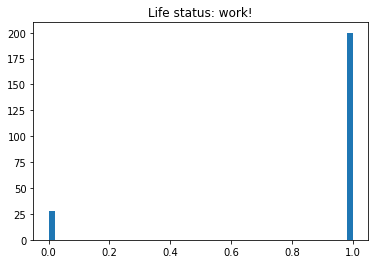

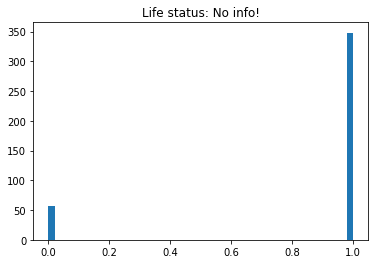

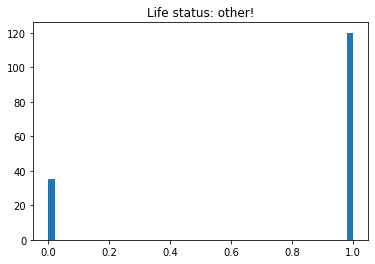

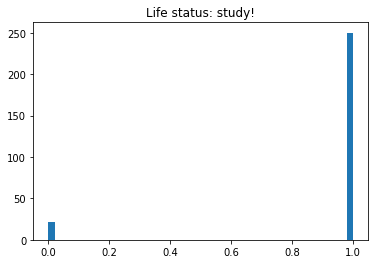

In [190]:
for status in train_data['Life status'].unique():
    current_data = train_data[train_data['Life status'] == status]
    plt.title('Life status: %s!' % status)
    plt.hist(current_data['contract_status'], bins=np.linspace(0, 1))
    plt.show()

Кажется, life status оказывал влияние на то, подписал человек договор или нет.

In [0]:
test_data['Life status'].fillna('No info', inplace=True)

##### Heard about school from

In [0]:
train_data['Heard about school from'].fillna('No info', inplace=True)

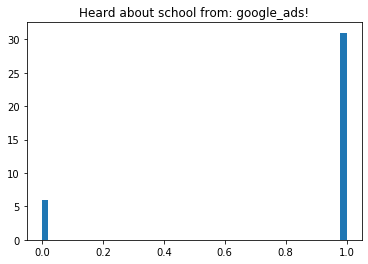

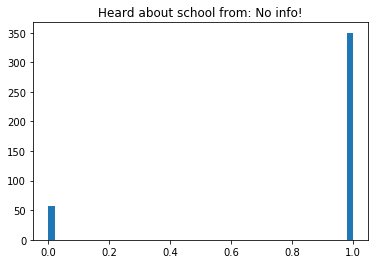

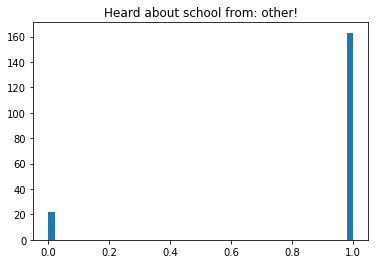

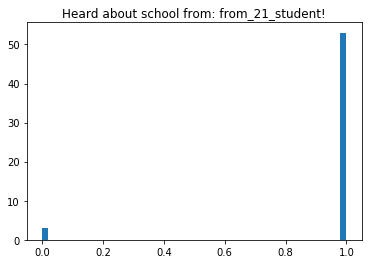

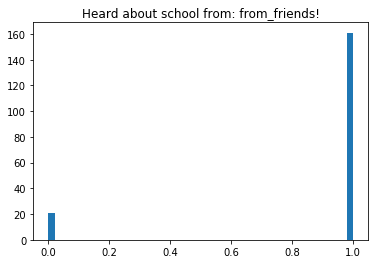

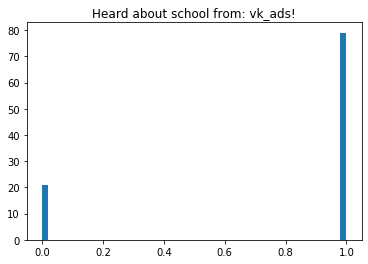

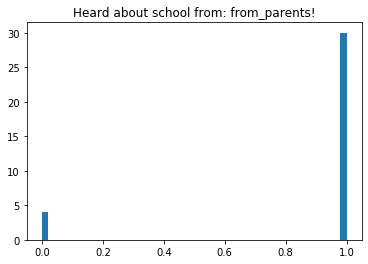

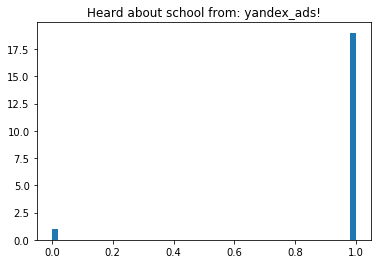

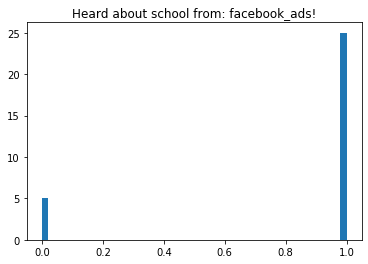

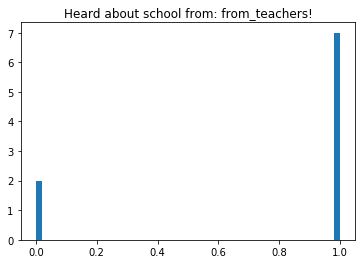

In [193]:
for status in train_data['Heard about school from'].unique():
    current_data = train_data[train_data['Heard about school from'] == status]
    plt.title('Heard about school from: %s!' % status)
    plt.hist(current_data['contract_status'], bins=np.linspace(0, 1))
    plt.show()

'Heard about school from' тоже влияет на то, подписал договор человек или нет.



In [0]:
test_data['Heard about school from'].fillna('No info', inplace=True)

Assertion that data is alright

In [0]:
assert not train_data.isnull().any().any() and not test_data.isnull().any().any()

In [0]:
train_data['contract_status'] = train_data['contract_status'].astype(bool)

### Обучение

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
y_pred = train_data['contract_status']
del train_data['contract_status']

X_train, X_val, y_train, y_val = train_test_split(train_data, y_pred, train_size=0.8, random_state=42)

In [0]:
try:
  from catboost import CatBoostClassifier, Pool
except ModuleNotFoundError:
  !pip install catboost
  from catboost import CatBoostClassifier, Pool

In [0]:
cat_boost_params = {
    'task_type': 'CPU',
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'iterations': 10**5,
    'od_pval': 1e-5,
    'learning_rate': 0.005,
    'random_state': 41
}

In [0]:
positive_proportion = y_train.shape[0] / y_train.sum() #балансируем классы

train_weights = [positive_proportion if label else 1 for label in y_train]

In [211]:
train = Pool(X_train, y_train, cat_features=train_data.columns[train_data.dtypes == object].tolist(), weight=train_weights)
val = Pool(X_val, y_val, cat_features=train_data.columns[train_data.dtypes == object].tolist())
test = Pool(test_data, cat_features=train_data.columns[train_data.dtypes == object].tolist())

classifier = CatBoostClassifier(**cat_boost_params)

basemodel = classifier.fit(train, use_best_model=True, eval_set=val, verbose=250)

0:	learn: 0.6890558	test: 0.6891513	best: 0.6891513 (0)	total: 5.63ms	remaining: 9m 22s
250:	learn: 0.3474715	test: 0.3711838	best: 0.3711838 (250)	total: 1.27s	remaining: 8m 25s
500:	learn: 0.2875632	test: 0.3372759	best: 0.3372759 (500)	total: 2.56s	remaining: 8m 28s
750:	learn: 0.2540882	test: 0.3300739	best: 0.3300025 (745)	total: 3.87s	remaining: 8m 31s
1000:	learn: 0.2267133	test: 0.3261857	best: 0.3261337 (998)	total: 5.17s	remaining: 8m 31s
1250:	learn: 0.2014360	test: 0.3236620	best: 0.3236440 (1236)	total: 6.47s	remaining: 8m 31s
1500:	learn: 0.1776331	test: 0.3226191	best: 0.3226176 (1499)	total: 7.79s	remaining: 8m 31s
1750:	learn: 0.1596175	test: 0.3204082	best: 0.3204082 (1750)	total: 9.11s	remaining: 8m 30s
2000:	learn: 0.1435317	test: 0.3186929	best: 0.3186929 (2000)	total: 10.4s	remaining: 8m 30s
2250:	learn: 0.1292849	test: 0.3174189	best: 0.3172523 (2243)	total: 11.8s	remaining: 8m 33s
2500:	learn: 0.1169416	test: 0.3175595	best: 0.3172179 (2294)	total: 13.2s	remaini

### Предсказание

In [212]:
pred = basemodel.predict_proba(test)
pred

array([[0.10934   , 0.89066   ],
       [0.09475391, 0.90524609],
       [0.06921771, 0.93078229],
       ...,
       [0.05987175, 0.94012825],
       [0.0741155 , 0.9258845 ],
       [0.05520411, 0.94479589]])

In [0]:
ans = pd.DataFrame()

ans['id'] = test_data['id']
ans['contract_status'] = pred[:, 1]

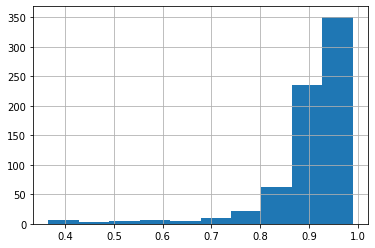

In [214]:
ans.contract_status.hist()

In [215]:
ans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706 entries, 0 to 705
Data columns (total 2 columns):
id                 706 non-null int64
contract_status    706 non-null float64
dtypes: float64(1), int64(1)
memory usage: 11.2 KB


In [216]:
ans.head()

,id,contract_status
0,685512434,0.890660
1,157712083,0.905246
2,672158583,0.930782
3,1205321261,0.888059
4,621191476,0.674549


In [0]:
ans.to_csv('float_prediction.csv', index=False)

In [0]:
sum(ans['id'] == sample_submission['id'])

706

Было принято решение оставить эти признаки, т.к. они не дали нужного результата.

### Попытка №2

In [0]:
import numpy as np
import pandas as pd
import sklearn as sl

In [0]:
train = pd.read_csv("/content/drive/My Drive/train_after_clean.csv") # новые обработанные данные. Обработка в другой тетрадке

In [220]:
train.head()

,Birth date,Native city,Gender,Wave id,Level,Life status,day_00,day_01,day_02,day_03,day_04,day_05,day_06,day_07,day_08,day_09,day_10,day_11,day_12,day_13,evalexpr,match_n_match,bsq,rush_00,rush_01,rush_02,exam_00,exam_01,exam_02,exam_final,Memory entrance game,Logic entrance game,contract_status
0,30,0,1,3,7.463235,1,5,0.0,0.0,80.0,0.0,1.0,0.0,15.0,10.0,0.0,50.0,21.0,20.0,55.0,81.0,0.0,0.0,0.0,0.0,0.0,75.0,43.0,100.0,44.0,9,11,1
1,23,0,0,1,8.785714,0,0,0.0,10.0,45.0,5.0,1.0,35.0,0.0,5.0,16.0,0.0,9.0,0.0,10.0,0.0,0.0,0.0,110.0,0.0,0.0,0.0,16.0,22.0,22.0,7,10,1
2,27,0,0,2,6.775000,1,0,0.0,20.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,27.0,7,11,1
3,23,0,0,1,8.146104,0,5,0.0,35.0,25.0,20.0,2.0,70.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,27.0,9,6,1
4,51,0,1,3,4.272727,0,0,0.0,0.0,5.0,85.0,3.0,50.0,40.0,0.0,12.0,40.0,5.0,0.0,0.0,0.0,60.0,0.0,120.0,0.0,0.0,80.0,38.0,0.0,45.0,7,12,1


In [0]:
train['contract_status'] = [str(train['contract_status'][i]) for i in np.arange(train.shape[0])]
train['Gender'] = [str(train['Gender'][i]) for i in np.arange(train.shape[0])]
train['Life status'] = [str(train['Life status'][i]) for i in np.arange(train.shape[0])]
train['Native city'] = [str(train['Native city'][i]) for i in np.arange(train.shape[0])]

In [222]:
train['max_score'] = train['rush_02']

for i in np.arange(train.shape[0]):
 train['max_score'][i] = max(train.iloc[i, 6:30])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [223]:
train.shape[1]

34

In [224]:
train.head()

,Birth date,Native city,Gender,Wave id,Level,Life status,day_00,day_01,day_02,day_03,day_04,day_05,day_06,day_07,day_08,day_09,day_10,day_11,day_12,day_13,evalexpr,match_n_match,bsq,rush_00,rush_01,rush_02,exam_00,exam_01,exam_02,exam_final,Memory entrance game,Logic entrance game,contract_status,max_score
0,30,0,1,3,7.463235,1,5,0.0,0.0,80.0,0.0,1.0,0.0,15.0,10.0,0.0,50.0,21.0,20.0,55.0,81.0,0.0,0.0,0.0,0.0,0.0,75.0,43.0,100.0,44.0,9,11,1,100.0
1,23,0,0,1,8.785714,0,0,0.0,10.0,45.0,5.0,1.0,35.0,0.0,5.0,16.0,0.0,9.0,0.0,10.0,0.0,0.0,0.0,110.0,0.0,0.0,0.0,16.0,22.0,22.0,7,10,1,110.0
2,27,0,0,2,6.775000,1,0,0.0,20.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,27.0,7,11,1,27.0
3,23,0,0,1,8.146104,0,5,0.0,35.0,25.0,20.0,2.0,70.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,27.0,9,6,1,70.0
4,51,0,1,3,4.272727,0,0,0.0,0.0,5.0,85.0,3.0,50.0,40.0,0.0,12.0,40.0,5.0,0.0,0.0,0.0,60.0,0.0,120.0,0.0,0.0,80.0,38.0,0.0,45.0,7,12,1,120.0


In [225]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060 entries, 0 to 1059
Data columns (total 34 columns):
Birth date              1060 non-null int64
Native city             1060 non-null object
Gender                  1060 non-null object
Wave id                 1060 non-null int64
Level                   1060 non-null float64
Life status             1060 non-null object
day_00                  1060 non-null int64
day_01                  1060 non-null float64
day_02                  1060 non-null float64
day_03                  1060 non-null float64
day_04                  1060 non-null float64
day_05                  1060 non-null float64
day_06                  1060 non-null float64
day_07                  1060 non-null float64
day_08                  1060 non-null float64
day_09                  1060 non-null float64
day_10                  1060 non-null float64
day_11                  1060 non-null float64
day_12                  1060 non-null float64
day_13                  1060

In [0]:
from sklearn.model_selection import train_test_split 

In [0]:
y_pred = train['contract_status']
del train['contract_status']

X_train, X_val, y_train, y_val = train_test_split(train, y_pred, train_size=0.9, random_state=42)

In [0]:
try:
  from catboost import CatBoostClassifier, Pool
except ModuleNotFoundError:
  !pip install catboost
  from catboost import CatBoostClassifier, Pool

In [0]:
#Параметры, найденные с помощью гридсерч
cat_boost_params = { 
    'task_type': 'CPU',
    'loss_function': 'CrossEntropy',
    'eval_metric': 'Logloss',
    'iterations': 10 ** 5,
    'od_pval': 1e-5,
    'grow_policy': 'Lossguide',
    'bootstrap_type': 'Bernoulli',
    'learning_rate': 0.005,
    #'subsample': 0.66
}

In [232]:
train = Pool(X_train, y_train)
val = Pool(X_val, y_val)

classifier = CatBoostClassifier(**cat_boost_params)

basemodel = classifier.fit(train, use_best_model=True, eval_set=val)

0:	learn: 0.6876925	test: 0.6882191	best: 0.6882191 (0)	total: 5.79ms	remaining: 9m 39s
1:	learn: 0.6832350	test: 0.6840173	best: 0.6840173 (1)	total: 11.7ms	remaining: 9m 43s
2:	learn: 0.6794400	test: 0.6806098	best: 0.6806098 (2)	total: 16.7ms	remaining: 9m 17s
3:	learn: 0.6748430	test: 0.6765645	best: 0.6765645 (3)	total: 22.5ms	remaining: 9m 23s
4:	learn: 0.6701988	test: 0.6721993	best: 0.6721993 (4)	total: 28ms	remaining: 9m 19s
5:	learn: 0.6660596	test: 0.6685916	best: 0.6685916 (5)	total: 33.2ms	remaining: 9m 12s
6:	learn: 0.6606887	test: 0.6632850	best: 0.6632850 (6)	total: 39.3ms	remaining: 9m 21s
7:	learn: 0.6562165	test: 0.6593305	best: 0.6593305 (7)	total: 44.3ms	remaining: 9m 14s
8:	learn: 0.6508399	test: 0.6540778	best: 0.6540778 (8)	total: 49.9ms	remaining: 9m 14s
9:	learn: 0.6457687	test: 0.6495598	best: 0.6495598 (9)	total: 55.7ms	remaining: 9m 16s
10:	learn: 0.6426618	test: 0.6465984	best: 0.6465984 (10)	total: 60.7ms	remaining: 9m 11s
11:	learn: 0.6382115	test: 0.642

In [0]:
#0.1398666078 - лучший скор

In [0]:
test = pd.read_csv("/content/drive/My Drive/test_data_after_clean.csv")

In [234]:
test['max_score'] = test['rush_02']

for i in np.arange(test.shape[0]):
 test['max_score'][i] = max(test.iloc[i, 6:30])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
prediction = basemodel.predict_proba(test)

In [0]:
ans = pd.DataFrame()

ans['id'] = test_data['id']

In [0]:
i_tried = []

for i in np.arange(len(prediction)):
  i_tried.append(prediction[i][1])

In [0]:
ans['contract_status'] = i_tried

In [239]:
ans.head()

,id,contract_status
0,685512434,0.987446
1,157712083,0.794113
2,672158583,0.993922
3,1205321261,0.995903
4,621191476,0.915638


In [0]:
ans.to_csv("prediction_to_sub4.csv", index=False)